# Gemini Practice Workshop: The Hands-On Lab Session

During This Session:

- You will learn a little bit about Jupyter, a web-based programming environment.
- You will learn a little Python, a popular programming language.
- You will explore an RF signal dataset.
- You will learn about hamming fingerprints.
- You will use Gemini to search a RF signal dataset where each signal is represented by a hamming fingerprint.
- You will use search results to classify unknown RF signals using a technique called KNN

To help solidify your understanding, you will be presented with exercises along the way.  OK, Let's Get Started !
***

# What Is Jupyter?

* Jupyter is the web-based programming environment that you are in right now.  
* A Jupyter "notebook" is composed of a bunch of "cells" stacked on top of each other.  
* Some cells are for documentation (like this one.) 
* Some cells are for Python code.
* Some cells show the output of code cells.  
* This will become more obvious as we proceed through this notebook.
***

# Exercise 1

Now for your first exercise:  
* The cell right below this one contains some code.  Click once in the code cell.  This will make the cell active ( notice the blue outline. )  
* Locate the "play" button in the toolbar at the top of the notebook.  You should see an image appear right below the code.
***

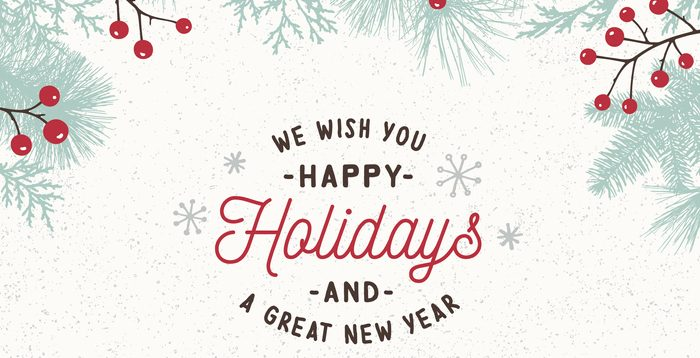

In [1]:
from IPython.display import Image
Image("surprise.jpg") 

# What Is Python?

Congratulations.  If you got the image to appear, you successfully ran python code in this Jupyter notebook!  Python is a popular programming language and we will use it throughout this session.

***

# Exercise 2

* The cell right below this one contains some code.  Run it and you will notice it will print a random number right below it.
* Trying running it several times.  Notice it will display a different random number each time.  ( Note that you will need to click on the code cell to reselect it.  That's because Jupyter automatically hops to the next cell after execution. )

***

In [2]:
import random
print( random.random() )

0.935132397050551


***
# Radio Frequency Signal Classification

Alright, let's start to dig into the application we are showcasing in this session - RF Signal Classification.  This is an important application in government and aerospace:
* AAA
* BBB
* CCC

We will be using Gemini to help us classify unknown radio frequency (RF) signals.
***

# Exercise 3

* The cell right below this one contains some code to load an RF signal database.  Run it and you should notice a message indicating success right below the code cell.

***

In [3]:
import rf_signals
rf_signals.load()

rf signal database loaded!


***

# Exercise 4

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* The database has several types of signals with names like '64APSK', 'AM-SSB-WC', '32PSK', etc., and there are many examples of each in the database.  

***

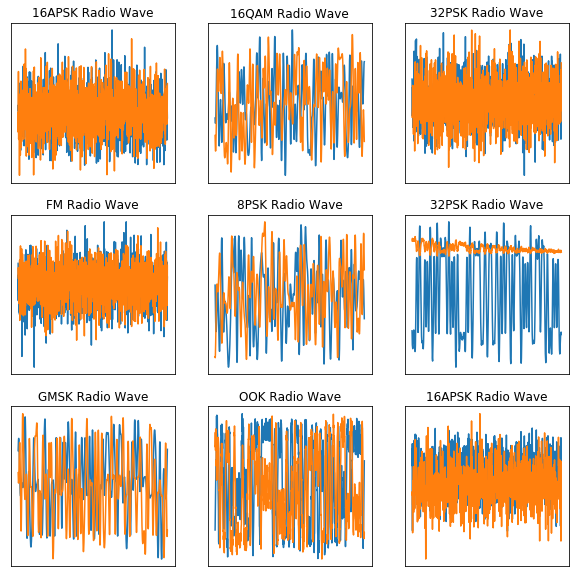

In [4]:
rf_signals.randisplay()

***
# Exercise 5

* Now let's load a different dataset of signals.  In this database, the signals haven't yet been classified.  
* Go ahead and run the next code cell to load the database of unknown signals.

***

In [5]:
import unknown_signals
unknown_signals.load()

unknown signal database loaded!


***

# Exercise 6

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* Remember, the signals in this database have not been classified yet!  That's why you see a question mark in the subplot titles.

***

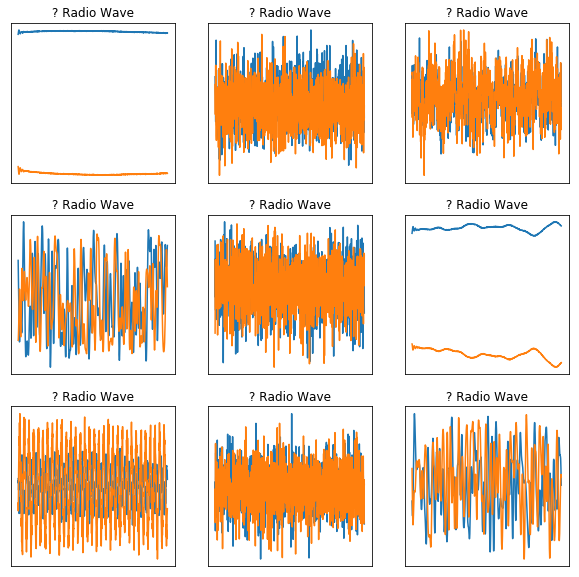

In [6]:
unknown_signals.randisplay()

***

# Exercise 7


***

In [7]:
import gnl
print(gnl.get_device_info())
gnl.init( rf_signals.get_fingerprints() )
search_results = gnl.search( unknown_signals.get_fingerprints() )

gnl initialized.
Search Complete!


Accuracy at snr = -20 and k = 5:  3.66
Accuracy at snr = -18 and k = 5:  4.2
Accuracy at snr = -16 and k = 5:  6.59
Accuracy at snr = -14 and k = 5:  9.28
Accuracy at snr = -12 and k = 5:  12.62
Accuracy at snr = -10 and k = 5:  14.93
Accuracy at snr = -8 and k = 5:  15.47
Accuracy at snr = -6 and k = 5:  18.89
Accuracy at snr = -4 and k = 5:  29.19
Accuracy at snr = -2 and k = 5:  40.0
Accuracy at snr = 0 and k = 5:  48.96
Accuracy at snr = 2 and k = 5:  56.74
Accuracy at snr = 4 and k = 5:  70.95
Accuracy at snr = 6 and k = 5:  79.4
Accuracy at snr = 8 and k = 5:  88.83
Accuracy at snr = 10 and k = 5:  94.02
Accuracy at snr = 12 and k = 5:  91.43
Accuracy at snr = 14 and k = 5:  92.22
Accuracy at snr = 16 and k = 5:  95.22
Accuracy at snr = 18 and k = 5:  94.93
Accuracy at snr = 20 and k = 5:  91.33
Accuracy at snr = 22 and k = 5:  92.66
Accuracy at snr = 24 and k = 5:  94.86
Accuracy at snr = 26 and k = 5:  95.03
Accuracy at snr = 28 and k = 5:  94.53
Accuracy at snr = 30 and k = 5:

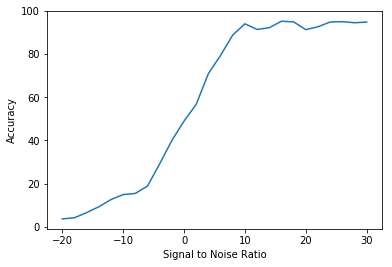

[0, 16, 19, 1, 21, 13, 9, 13, 20, 13]


In [8]:
import knn
predictions = knn.classify( rf_signals.get_labels(), unknown_signals.get_labels(), search_results, plot=True )
print(predictions[0:10])

In [10]:
#knn.randisplay( predictions, rf_signals, unknown_signals )